### 0. Setup

In [1]:
import sys
ROOT_DIR = "../"
sys.path.append(ROOT_DIR)

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter
from utils.common import print_blue, print_green, print_red

In [3]:
%%time
heart_rate_dict = joblib.load("../processed_data/master_heart_rates.pkl")
resp_rate_dict = joblib.load("../processed_data/master_resp_rates.pkl")

CPU times: user 21.8 ms, sys: 97.6 ms, total: 119 ms
Wall time: 124 ms


In [4]:
def plot_loss(history, metric_name="loss", until=None):
    if until is None:
        until = -1
    plt.figure(figsize=(15, 6))
    plt.plot(np.array(history[metric_name][:until]))
    plt.plot(np.array(history[f'val_{metric_name}'][:until]))
    plt.title('MSE by epochs')
    plt.ylabel('MSE (bpm^2)')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### 2.0 Subsampling
- Data is 25 Hz, we use N seconds data, which means N * 25 data points 

In [5]:
NUMBER_OF_SECONDS = 30 * 1
SUBSAMPLE_LENGTH = int(25 * NUMBER_OF_SECONDS)
NUMBER_OF_SAMPLES_PER_INFANT = 15000
RESP_DIM = 2

In [6]:
heart_scaler = StandardScaler()
resp_scaler = StandardScaler()

In [7]:
train_resp_samples, train_heart_samples = [], []
val_resp_samples, val_heart_samples = [], []
test_resp_samples, test_heart_samples = [], []
error_dict = {}
for infant in tqdm(range(1, 11)):
    if infant in [1, 5, 10]:
        continue
    np.random.seed(1020)
    start_indices = np.random.choice(len(resp_rate_dict[infant]), size=NUMBER_OF_SAMPLES_PER_INFANT, replace=False)
    end_indices = start_indices + SUBSAMPLE_LENGTH
    for s, e in zip(start_indices, end_indices):
        r = resp_rate_dict[infant][s: e]
        h = heart_rate_dict[infant][s: e]
        
        r = resp_scaler.fit_transform(r.reshape(-1, 1))
        r_lag = pd.Series(r.reshape(-1, )).diff(-1).fillna(0).values
        # r_lag2 = pd.Series(r.reshape(-1, )).diff(-2).fillna(0).values
        # r_lag3 = pd.Series(r.reshape(-1, )).diff(-3).fillna(0).values
        
        if any([
            np.mean(r) == 0, np.mean(h) == 0, 
            np.count_nonzero(np.isnan(r)) > 0, np.count_nonzero(np.isnan(h)), 
            e > resp_rate_dict[infant].shape[0]
        ]):
            try:
                error_dict[infant] += 1
            except:
                error_dict[infant] = 1
            continue
        
        final_r = np.concatenate([r, r_lag.reshape(-1, 1)], axis=1)
        # , r_lag2.reshape(-1, 1), r_lag3.reshape(-1, 1)
        # Only infant with ECG Lead Type II data is used
        if infant in [2, 3, 4]:
            train_resp_samples.append(final_r)
            train_heart_samples.append(h)
        elif infant in [6, 7]:
            val_resp_samples.append(final_r)
            val_heart_samples.append(h)
        elif infant in [8, 9]:
            test_resp_samples.append(final_r)
            test_heart_samples.append(h)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


### 2.1 Invalid Proportion Check

In [8]:
c = Counter(error_dict)

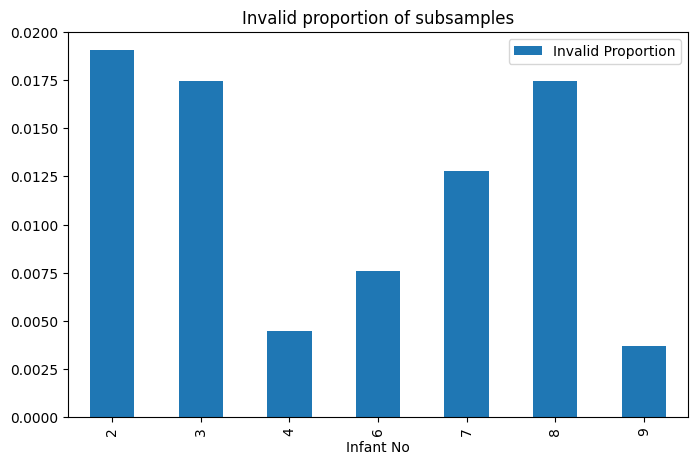

In [9]:
pd.DataFrame([c[key] / NUMBER_OF_SAMPLES_PER_INFANT for key in c.keys()], index=c.keys(), columns=["Invalid Proportion"]).plot.bar(figsize=(8, 5))
plt.title("Invalid proportion of subsamples")
plt.xlabel("Infant No")
plt.show()

### 2.2 Data Splitting

In [10]:
def convert_to_array(list_, dim1=1):
    array = np.array(list_)
    array = array.reshape(-1, dim1, SUBSAMPLE_LENGTH)
    return array

In [11]:
%%time
train_resp = convert_to_array(train_resp_samples, dim1=RESP_DIM)
val_resp = convert_to_array(val_resp_samples, dim1=RESP_DIM)
test_resp = convert_to_array(test_resp_samples, dim1=RESP_DIM)

CPU times: user 219 ms, sys: 1.03 s, total: 1.25 s
Wall time: 209 ms


In [12]:
train_heart = convert_to_array(train_heart_samples)
val_heart = convert_to_array(val_heart_samples)
test_heart = convert_to_array(test_heart_samples)


In [13]:
train_resp.shape, train_heart.shape

((44385, 2, 750), (44385, 1, 750))

In [14]:
def plot_heart_resp(heart_rate_data, resp_data, prediction=None, figsize=(18, 7)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    time_coor = np.arange(resp_data.shape[0]) / 25
    ax.plot(time_coor, resp_data, label="resp", color="blue", alpha=0.8)
    ax.legend(loc=2)
    ax2 = ax.twinx()
    ax2.plot(time_coor, heart_rate_data, label="heart rate", color="red", alpha=1)
    if prediction is not None:
        ax2.plot(time_coor, prediction, label="prediction", color="orange", alpha=1)
    ax2.legend(loc=1)
    plt.title("Heart Rate Prediction Sample")
    plt.xlabel("seconds")
    plt.show()

### 2.3 Defined Model

In [15]:
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, Dense, Activation, Reshape, TimeDistributed, Dropout, Bidirectional, concatenate
from keras.optimizers import Adam, RMSprop

In [16]:
FIRST_LSTM_SIZE = 64
DECODER_LSTM_SIZE = 64

In [17]:
encoder_inputs = Input(shape=(RESP_DIM, SUBSAMPLE_LENGTH))
encoder_outputs, h1, c1, h2, c2 = Bidirectional(
    LSTM(
     FIRST_LSTM_SIZE, activation="tanh", recurrent_activation="swish", recurrent_dropout=0.5, return_state=True, return_sequences=True
    )
)(encoder_inputs)
decoder_inputs = encoder_outputs

In [18]:
decoder_outputs, decoder_state_h, decoder_state_c = LSTM(
    FIRST_LSTM_SIZE, return_sequences=True, return_state=True
)(
    encoder_outputs, 
    initial_state=[h1, c1]
)
decoder_outputs = Reshape(target_shape=(RESP_DIM, FIRST_LSTM_SIZE))(decoder_outputs)

In [19]:
decoder_outputs = TimeDistributed(Dense(8, activation='swish'))(decoder_outputs)
decoder_outputs = Dropout(0.6, input_shape=decoder_outputs.shape)(decoder_outputs)
decoder_outputs = Dense(SUBSAMPLE_LENGTH, activation='linear')(decoder_outputs)

In [20]:
model = Model(encoder_inputs, decoder_outputs)
opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss="mean_squared_error")

In [21]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [22]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 750)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 2, 128),     417280      ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64),                                                      
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                              

In [24]:
history = model.fit(
    x=train_resp, 
    y=train_heart, 
    batch_size=64, 
    epochs=20, 
    verbose=1, 
    validation_data=(val_resp, val_heart)
)

Epoch 1/20


2023-02-03 17:31:27.449038: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


694/694 [==============================] - 10s 11ms/step - loss: 6002.8799 - val_loss: 1499.7889
Epoch 2/20
694/694 [==============================] - 7s 11ms/step - loss: 4712.7246 - val_loss: 1531.0341
Epoch 3/20
694/694 [==============================] - 8s 11ms/step - loss: 3796.6377 - val_loss: 1730.2555
Epoch 4/20
694/694 [==============================] - 8s 12ms/step - loss: 3253.0161 - val_loss: 1330.2079
Epoch 5/20
694/694 [==============================] - 9s 13ms/step - loss: 2883.0200 - val_loss: 943.4489
Epoch 6/20
694/694 [==============================] - 9s 13ms/step - loss: 2538.7961 - val_loss: 1027.6029
Epoch 7/20
694/694 [==============================] - 9s 13ms/step - loss: 2267.7410 - val_loss: 828.0399
Epoch 8/20
694/694 [==============================] - 9s 13ms/step - loss: 2040.7035 - val_loss: 807.8040
Epoch 9/20
694/694 [==============================] - 10s 14ms/step - loss: 1849.4078 - val_loss: 705.0682
Epoch 10/20
694/694 [=============================

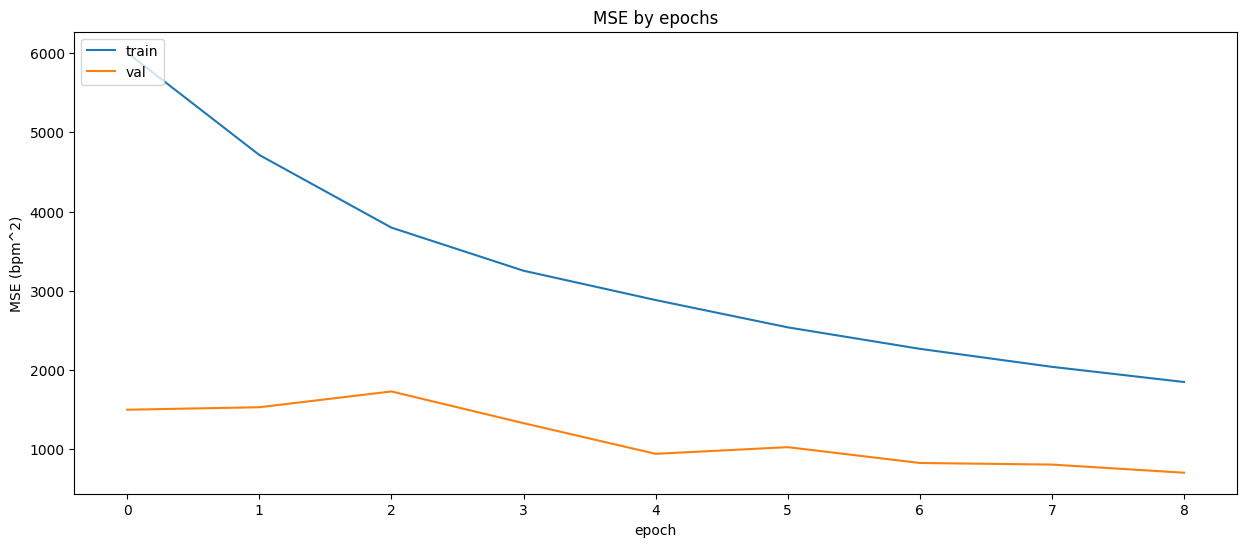

In [25]:
plot_loss(history.history, until=9)

In [26]:
index = 3
t = int(len(train_heart_samples[index]) / 2)

1/1 [==============================] - 0s 397ms/step


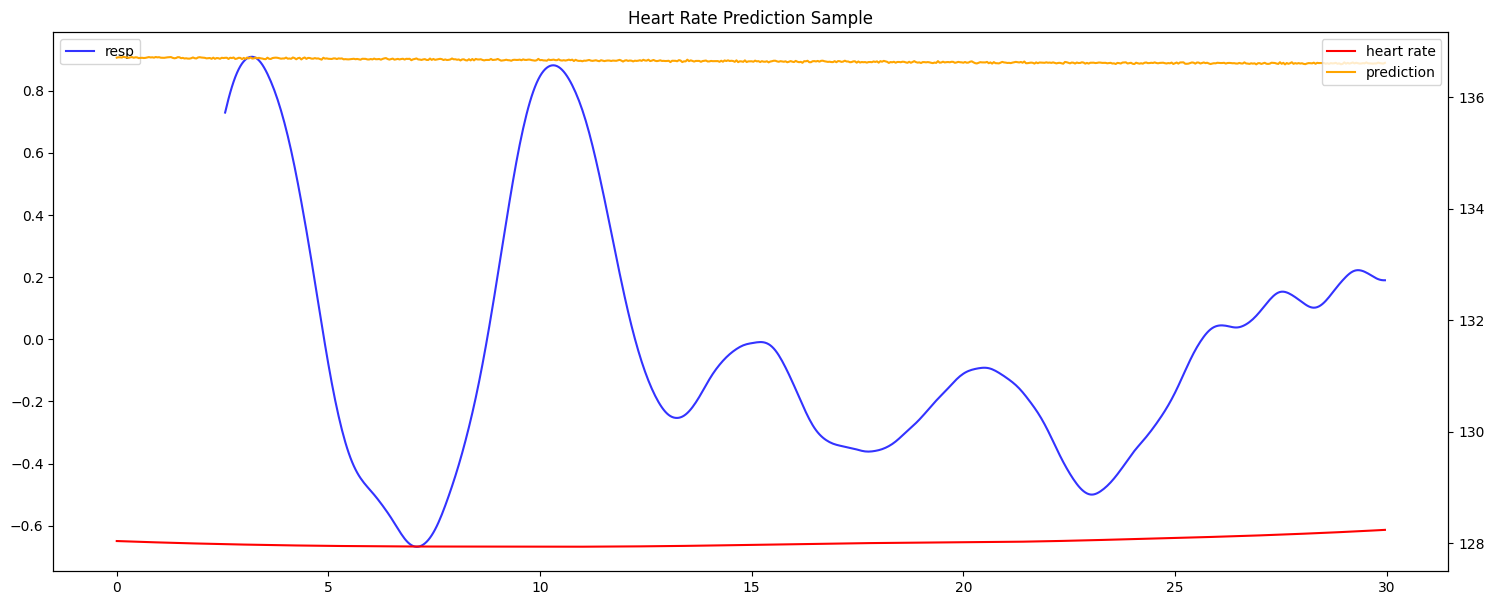

In [27]:
index = 13
plot_heart_resp(
    train_heart_samples[index], 
    pd.Series(train_resp_samples[index].reshape(SUBSAMPLE_LENGTH, -1).mean(axis=1)).rolling(60).mean().rolling(6).mean().values, 
    model.predict(train_resp[index].reshape(-1, RESP_DIM, SUBSAMPLE_LENGTH)).mean(axis=1).reshape(SUBSAMPLE_LENGTH, -1)
)

- The model is underfit, as it tends to predict towards the global average of the training samples heart rate
- For this particular subsample, the subsample heart rate is below the global average, therefore the model is overestimate

In [28]:
train_pred = model.predict(train_resp).mean(axis=1)
val_pred = model.predict(val_resp).mean(axis=1)

928/928 [==============================] - 3s 3ms/step


In [32]:
test_pred = model.predict(test_resp).mean(axis=1)

928/928 [==============================] - 3s 3ms/step


In [33]:
train_heart = train_heart.reshape(-1, SUBSAMPLE_LENGTH)
val_heart = val_heart.reshape(-1, SUBSAMPLE_LENGTH)
test_heart = test_heart.reshape(-1, SUBSAMPLE_LENGTH)

In [39]:
print_green(f"Train MSE = {np.mean(np.abs(train_heart - train_pred) ** 2)}")
print_green(f"Train Avg Correlation Coefficient: {np.mean([np.corrcoef(train_heart[i], train_pred[i]) for i in range(train_pred.shape[0])])}")
print_blue(f"Validation MSE = {np.mean(np.abs(val_heart - val_pred) ** 2)}")
print_blue(f"Validation Avg Correlation Coefficient: {np.mean([np.corrcoef(val_heart[i], val_pred[i]) for i in range(val_pred.shape[0])])}")
print_red(f"Test MSE = {np.mean(np.abs(test_heart - test_pred) ** 2)}")
print_red(f"Validation Avg Correlation Coefficient: {np.mean([np.corrcoef(test_heart[i], test_pred[i]) for i in range(test_pred.shape[0])])}")

Train MSE = 471.79890554392233
Train Avg Correlation Coefficient: 0.48681809670469844
Validation MSE = 424.5329056444706
Validation Avg Correlation Coefficient: 0.5261888832549667
Test MSE = 204.53393587250335
Validation Avg Correlation Coefficient: 0.5117727591212937
